### Targeted lipidomics analysis of Pancreas Tissue using LC-MS (Xcalibur) 
#### Comparison is healthy donors, type 1 diabetes donors and type 2 diabetes donors 
###### Details regarding sample groups can be found in README

In [2]:
### Import necessary libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import scipy as sp

import sklearn as sk

from sklearn.decomposition import PCA
from scipy.stats import zscore

In [3]:
### Loading lipidomics dataset into pandas df

# Load dataset
lipidomicsDF = pd.read_csv('lipidomicsdatafinal.csv')

# Create a deep copy for analysis
lipidomicsRawAnalysisDf = lipidomicsDF.copy()

# Quick inspection of data types and nulls
lipidomicsRawAnalysisDf.head()

# Make SampleID the index
lipidomicsRawAnalysisDf.set_index('Samples', inplace=True)

# print(lipidomicsRawAnalysisDf.head)
# Statistical summary
# lipidomicsRawAnalysisDf.describe()

In [4]:
# How many zero values are in each column/lipid species

# Count zeros for each column (lipids)
zeroCountsLipids = (lipidomicsRawAnalysisDf == 0.0).sum()

# Count zeros for each row (donors/samples)
zeroCountsDonors = (lipidomicsRawAnalysisDf == 0.0).sum(axis=1)

# Create DataFrame with donor names, zero counts, and percentage
totalLipids = lipidomicsRawAnalysisDf.shape[1]  # Total number of columns (lipids)

zeroCountsDonorsDf = pd.DataFrame({
    'Samples': lipidomicsRawAnalysisDf.index,
    'ZeroCount': zeroCountsDonors.values,
    'ZeroPercentage': (zeroCountsDonors.values / totalLipids) * 100
})

# Similarly for lipids
totalDonors = lipidomicsRawAnalysisDf.shape[0]  # Total number of rows (donors)

zeroCountsLipidsDf = pd.DataFrame({
    'Lipid': zeroCountsLipids.index,
    'ZeroCount': zeroCountsLipids.values,
    'ZeroPercentage': (zeroCountsLipids.values / totalDonors) * 100
})

# Display first 40 entries of each
# zeroCountsLipidsDf.head(40)
zeroCountsDonorsDf.head(40)


,Samples,ZeroCount,ZeroPercentage
0,651_CR,31,10.689655
1,668_C,29,10.000000
2,671_C,26,8.965517
3,674_CR,26,8.965517
4,677_B,25,8.620690
5,679_CR,34,11.724138
6,682_B,27,9.310345
7,685_BR,32,11.034483
8,687_B,29,10.000000
9,690_B,23,7.931034


In [5]:
# Here we are looking for number of "Technical Nulls" (NaNs), not "Numerical Nulls" (Zeros).

# This scans every single cell in your DataFrame. If a cell contains a missing value (like NaN or None), it marks it as True. 
# If it contains a number (even 0), it marks it as False. 
# The first .sum() counts the number of True values in each individual column. 
# The second .sum() adds all those column totals together to give you one single integer representing every missing data point in the entire table

lipidIsNullMissing = lipidomicsRawAnalysisDf.isnull().sum().sum()
if lipidIsNullMissing == 0:
    print("There are no missing values in the dataset.")
else:
    print(f"Total missing values: {lipidIsNullMissing}")

There are no missing values in the dataset.


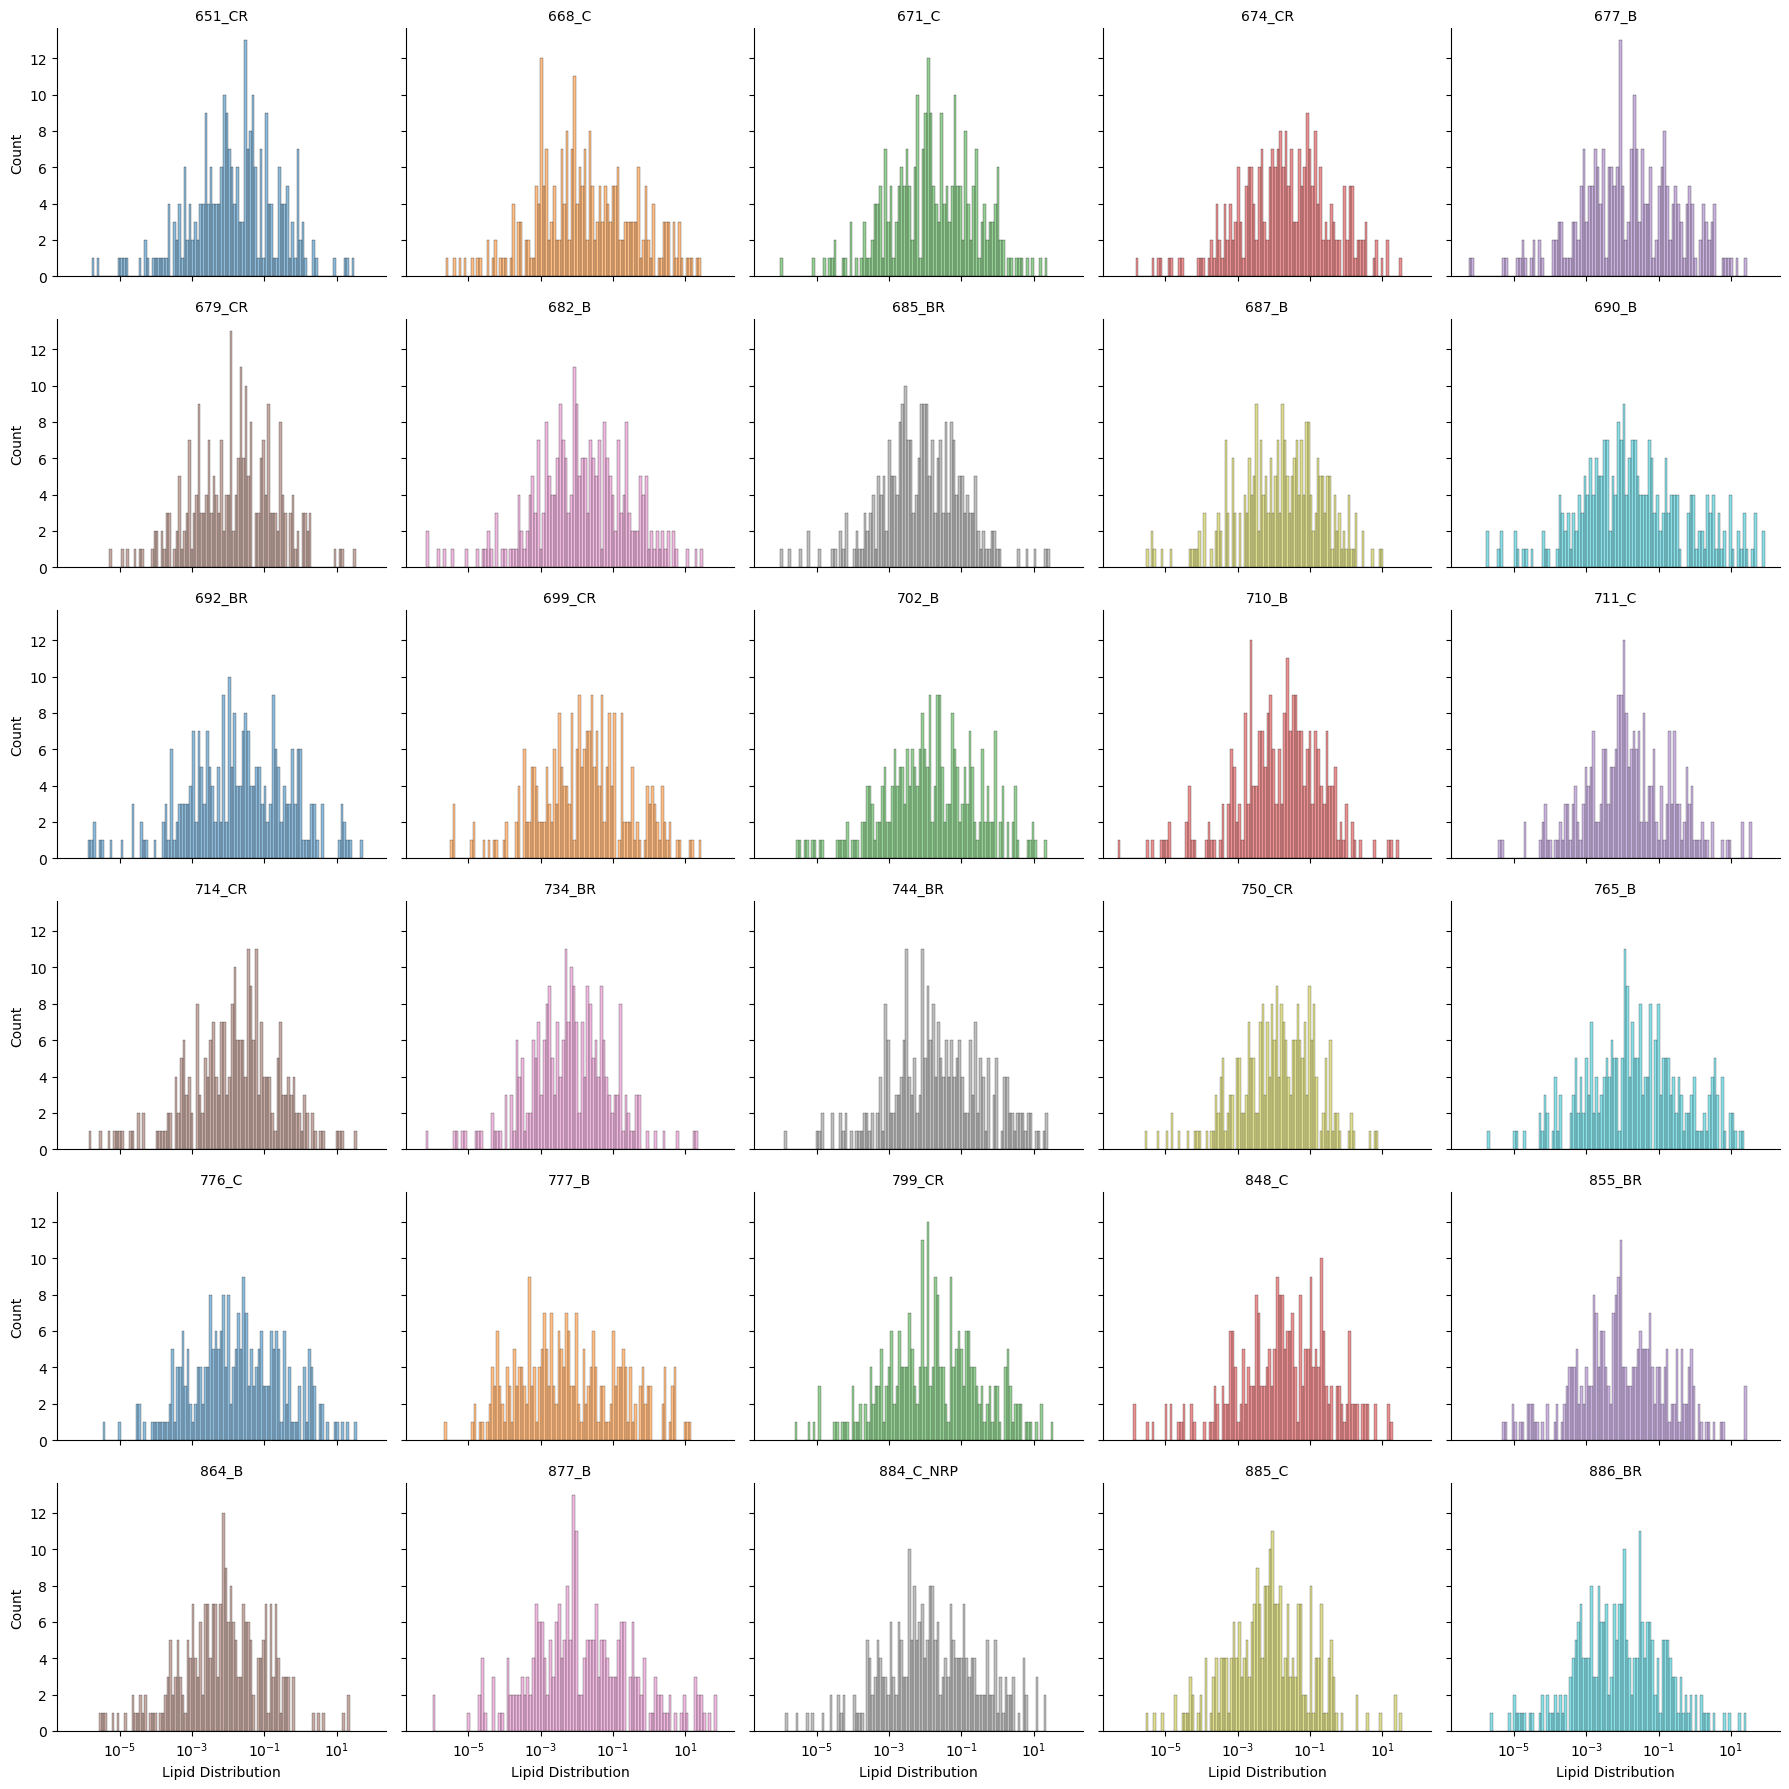

<Figure size 1400x600 with 0 Axes>

In [15]:
# Creating a simple histogram of lipid counts for each donor

# Melt the DataFrame to long format (excluding the 'Group' column)

# Get list of columns excluding 'Group'
dfColsNames = [col for col in lipidomicsRawAnalysisDf.columns if col != 'Group'] 

# Starts transforming the DataFrame from wide format to long format using pandas' melt() function.

# Reset index to convert 'Samples' from index to column
lipidomicsLongRawDf = lipidomicsRawAnalysisDf.reset_index().melt(
    id_vars = ['Samples', 'Group'],
    value_vars = dfColsNames,
    var_name = 'Lipid',
    value_name = 'Distribution'
)

# For simplicity rename T1DM_T2DM to T1DM and change the GESTATIONAL DIABETES to HEALTHY
lipidomicsLongRawDf['Group'] = lipidomicsLongRawDf['Group'].replace({
    'T1DM_T2DM': 'T1DM',
    'GESTATIONAL': 'HEALTHY'
})


# Begin plotting using seaborn's FacetGrid to create histograms for each donor/sample.
facetGridPlot = sns.FacetGrid(
    lipidomicsLongRawDf, 
    col='Samples',
    col_wrap=5, 
    hue='Samples', 
    aspect=1.2, 
    height=3, 
    palette='tab10'
)

facetGridPlot.map(
    sns.histplot, 
    'Distribution', 
    bins=100, 
    kde=True,
    log_scale=True 
)

facetGridPlot.set_titles(col_template="{col_name}")
facetGridPlot.set_xlabels('Lipid Distribution')

plt.figure(figsize=(14, 6))
plt.tight_layout()
plt.show()
plt.close()

In [16]:
# # Conversion of lipid names to RefMet (Reference Metabolome) standard format.

# lipidNamesDF = pd.read_csv('LipidomicsDataforConversion.csv')

# # Put the lipid names into a list for conversion

# lipidNamesOriginalList = lipidNamesDF['Lipid_Names'].tolist()

# # print(lipidNamesOriginalList[:5])

# # Initialise an empty list to store the converted/modified lipid names.

# lipidNamesAlteredList = []

# for lipid in lipidNamesOriginalList:
#      modifiedLipid = lipid.replace('_', ' ', 1)  # The '1' means to replace only the first occurrence with a space
#      modifiedLipid = modifiedLipid.replace('_', ':', 2) # The '2' means to replace the next underscore with a colon
#      if 'Carnitine' in modifiedLipid:
#          modifiedLipid = modifiedLipid.replace('Carnitine', 'CAR')
#      elif 'S ' in modifiedLipid:
#         modifiedLipid = modifiedLipid.replace('S ', 'SHexCer')
#      lipidNamesAlteredList.append(modifiedLipid)

# #print(lipidNamesAlteredList[:20])

# filenameForCorrectLipidList = 'convertedlipidnames.txt'

# # Write the list to a .txt file  

# with open(filenameForCorrectLipidList, 'w') as file:  
#     for lipid in lipidNamesAlteredList:  
#         file.write(lipid + '\n')  # Write each lipid name followed by a newline  

# print(f"Lipid names have been written to {filenameForCorrectLipidList}.") 



This data contains left-censored MNAR data which must be dealt with

Therefore, the modified 80% rule will be used ("variables can be excluded from the data when the proportion of non-missing elements are accounted for less than 80% among each biological group") 

After this, QRILC Imputation will be used in R script called "QRILC_Imputation" using the package imputeLCMD, which has been shown to perform best on left-censored MNAR data 

https://doi.org/10.1038/s41598-017-19120-0


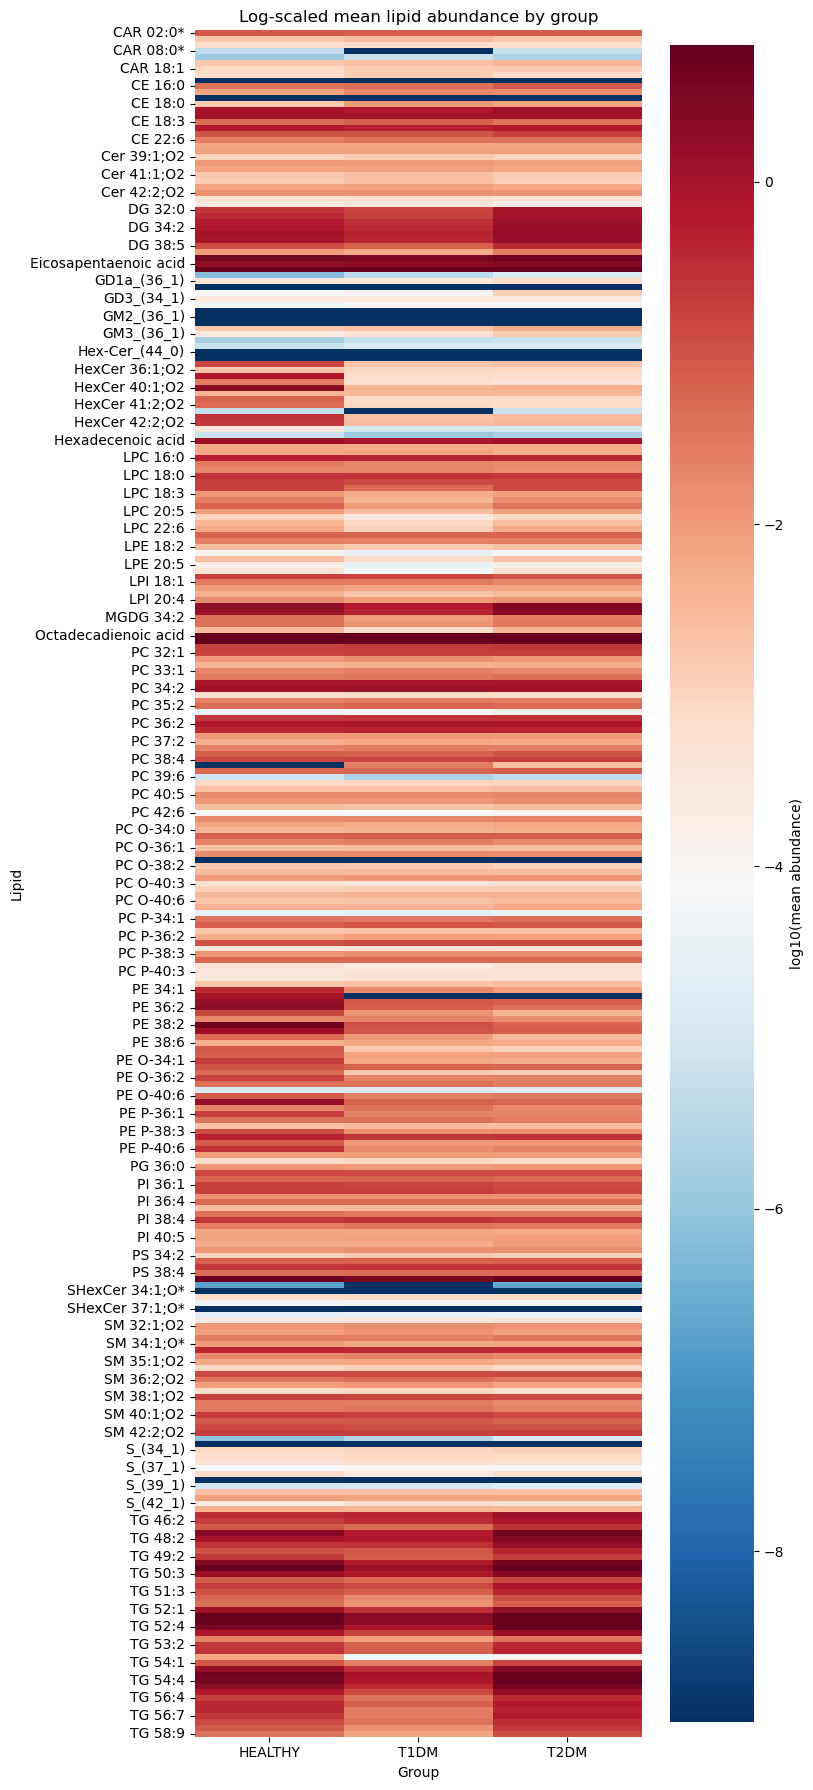

<Figure size 800x1800 with 0 Axes>

<Figure size 800x1800 with 0 Axes>

In [ ]:
# Generate a general heatmap of all lipids across all groups

lipidomicsRawAnalysisDf['Group'] = lipidomicsRawAnalysisDf['Group'].replace({
    'T1DM_T2DM': 'T1DM',
    'GESTATIONAL': 'HEALTHY'
})

heatmapEverythingDf = lipidomicsLongRawDf.pivot_table(
    index='Lipid',
    columns='Group',
    values='Distribution',
    aggfunc='mean'   # explicit, no magic
)

# Use log10 scale for better visualization
pseudoCount = 1e-9
heatmapEverythingLogDf = np.log10(heatmapEverythingDf + pseudoCount)

# plot heatmap
plt.figure(figsize=(8, 18))

sns.heatmap(
    heatmapEverythingLogDf,
    cmap='RdBu_r',
    robust=True,
    cbar_kws={'label': 'log10(mean abundance)'}
)

plt.xlabel('Group')
plt.ylabel('Lipid')
plt.title('Log-scaled mean lipid abundance by group')

plt.tight_layout()
plt.show()
plt.close()
plt.figure(figsize=(8, 18))


In [18]:
# Run the modified 80% rule to filter lipids based on non-zero values within groups

# Step 1: identify feature columns (exclude 'Group')
featureCols = [col for col in lipidomicsRawAnalysisDf.columns if col != 'Group']

# Step 2: create a boolean DataFrame: True if value is non-zero, False if zero
# This is elementwise, creating a DataFrame of booleans (True/False) the same shape as lipidomicsRawAnalysisDf[feature_cols]
nonZeroDf = (lipidomicsRawAnalysisDf[featureCols] != 0)

# Step 3: add the Group column to the boolean DataFrame for grouping
# We need the group information so we can calculate the fraction of non-zero values per group.
nonZeroDf['Group'] = lipidomicsRawAnalysisDf['Group']

# Step 4: compute the fraction of non-zero values per lipid per group
# nonZeroDf.groupby('Group') → splits the DataFrame into sub-DataFrames by unique group.
# .mean() on booleans treats True as 1, False as 0 → calculates fraction of non-zero samples for each lipid in each group.
fractions = nonZeroDf.groupby('Group').mean()

# Step 5: find lipids where the fraction >= 0.8 in any group
keepMask = (fractions >= 0.8).any(axis=0)

# Step 6: apply the mask to keep only the desired lipids + Group column
modified80LipidDf = lipidomicsRawAnalysisDf[['Group'] + keepMask[keepMask].index.tolist()]

print("Original number of lipids:", len(featureCols))
print("Number of lipids after modified 80% rule:", len(modified80LipidDf.columns)-1)


Original number of lipids: 289
Number of lipids after modified 80% rule: 260


In [ ]:
# Export the modified DataFrame to a new CSV file for Imputation on R script

modified80LipidDf.index.name = 'Samples'  # Name the index
modified80LipidDf.to_csv('LipidomicsDataModified80PercentRule.csv', index=True)

             Group  CAR 02:0*  CAR 03:0*  CAR 05:0*  CAR 18:0  CAR 18:1  \
Samples                                                                   
651_CR        T2DM   0.048330   0.002429   0.000724  0.008422  0.003501   
668_C         T2DM   0.057002   0.000990   0.000313  0.002578  0.000808   
671_C         T2DM   0.146065   0.003168   0.001261  0.005503  0.002549   
674_CR        T2DM   0.067519   0.002190   0.000479  0.002110  0.000903   
677_B         T1DM   0.060186   0.001286   0.000444  0.002245  0.000898   
679_CR        T1DM   0.105556   0.003534   0.000810  0.000908  0.000676   
682_B         T2DM   0.073154   0.000919   0.000319  0.003254  0.001276   
685_BR        T1DM   0.074858   0.001686   0.000482  0.004257  0.001010   
687_B      HEALTHY   0.048516   0.000455   0.000239  0.001086  0.000479   
690_B         T2DM   0.094610   0.001307   0.000488  0.002572  0.000985   
692_BR     HEALTHY   0.109054   0.003197   0.000735  0.001195  0.000592   
699_CR        T2DM   0.03

QRLIC Imputaton completed on R script. Now finishing remaining analysis which includes another heatmap of imputed data and then PCA on the first five components

In [25]:
# Put the imputed csv file output from R into a pandas DataFrame for further analysis

# Load imputed data
imputedLipidDf = pd.read_csv("lipidomics_imputed_data.csv")

# Set Samples as index
imputedLipidDf = imputedLipidDf.set_index("Samples")

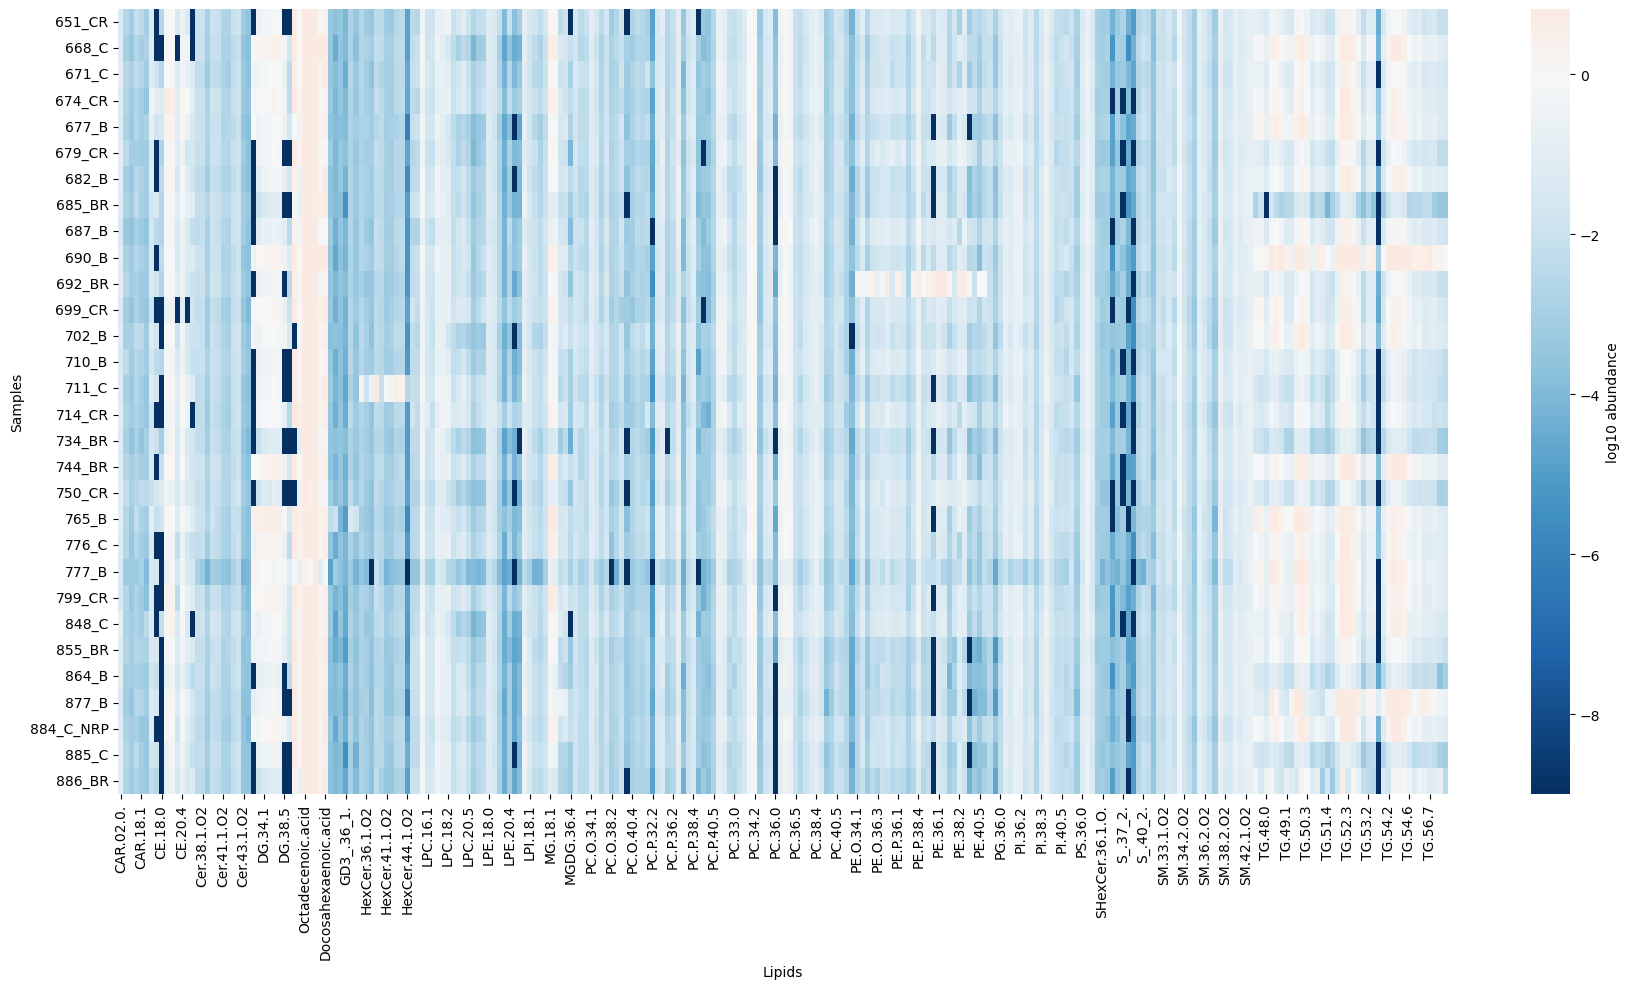

In [26]:
# Heatmap for lipids 

# Separate metadata and lipid matrix
groupLabels = imputedLipidDf["Group"]
lipidMatrix = imputedLipidDf.drop(columns=["Group"])

# Log-transform (recommended for QRILC output)
lipidMatrixLog = np.log10(lipidMatrix + 1e-9)

plt.figure(figsize=(18, 10))
sns.heatmap(
    lipidMatrixLog,
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "log10 abundance"}
)

plt.xlabel("Lipids")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()
plt.close()

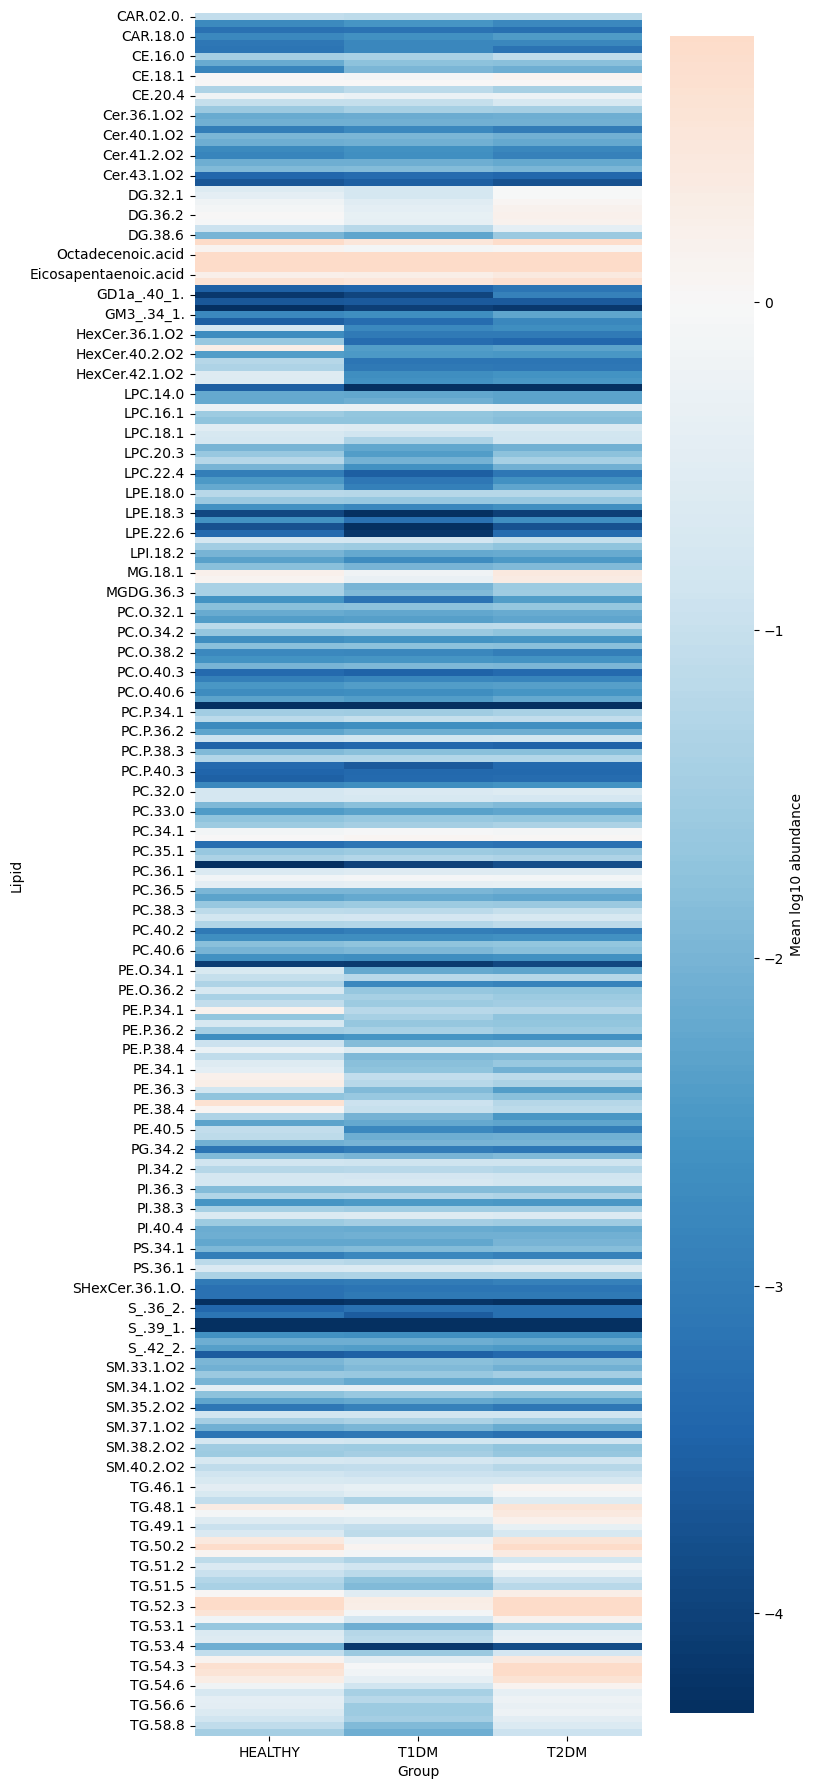

In [27]:
# Combine lipid data with group labels
lipidMatrixWithGroup = lipidMatrix.copy()
lipidMatrixWithGroup["Group"] = groupLabels

# Compute group means
groupMeansDf = lipidMatrixWithGroup.groupby("Group").mean()

# Transpose so lipids are rows
groupMeansTransposedDf = groupMeansDf.T

plt.figure(figsize=(8, 18))
sns.heatmap(
    np.log10(groupMeansTransposedDf + 1e-9),
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "Mean log10 abundance"}
)

plt.xlabel("Group")
plt.ylabel("Lipid")
plt.tight_layout()
plt.show()
plt.close()